In [1]:
import numpy as np
from dtw import fastdtw
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline

def dba_align(data, iterations=15,
              template=None):
    """Use DBA to align a collection of 1D time-series

    Args
    ----
    data : array-like
        single neuron raster across trials, shape = [n_trials, n_time]
    iterations : int
        number of iterations to run DBA
    template : array-like (optional)
        the initial template / dba average (if None, init with trial-average)
    center: bool (optional, default True)
        whether to center the warps when computing the template

    Returns
    -------
    template : np.ndarray
        Canonical timeseries identified by DBA
    warps : list of ndarray
        each element is a [n_index_matchings x 2] matrix holding the indices into
        the trial and into the template. The indices into the trial time series
        for trial k is `warps[k][:, 0]` and the indices into the template are
        `warps[k][:, 1]`. Note - the number of index matchings can be variable
        from trial to trial.
    cost_history : np.ndarray
        vector holding the cost function over
    """

    # objective history
    if template is None:
        template = data[0]

    cost_history = []
    K, T, N = data.shape

    # main optimization loop
    for itr in trange(iterations):
        cost_history.append(0.0)
        values = [list() for t in range(T)]
        warps = []
        # compute statistics for next template
        for tidx, trial in enumerate(data):
            dist, cost, acc, path = fastdtw(trial, template, dist = lambda x, y: np.sum((x-y)**2))
            cost_history[-1] += dist
            warps.append(np.array(path))
        # Apply warps to data
        for trial, idx in zip(data, warps):
            for i in idx.T:
                values[i[1]].append(trial[i[0]])
        # Add fudge factor in denominator to avoid divide by 0
        template = np.array([np.mean(v, axis=0) for v in values])

    return template, warps, cost_history

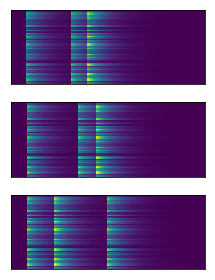

In [2]:
from twpca.datasets import jittered_population

data = jittered_population()[0]# + jittered_population()[0]

fig, axes = plt.subplots(3, 1)
for ax, trial in zip(axes, data):
    ax.imshow(trial.T)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [3]:
template, warps, cost_history = dba_align(data[:10])

100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


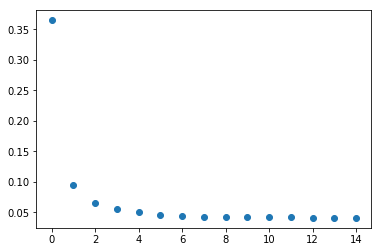

In [4]:
plt.plot(cost_history, 'o')

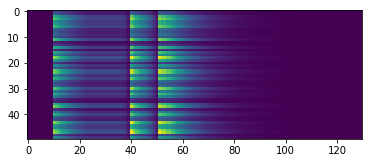

In [6]:
plt.imshow(template.T)

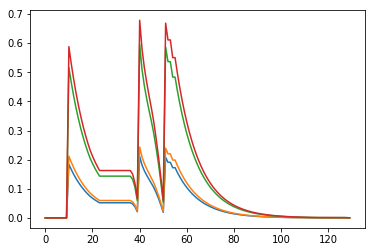

In [10]:
plt.plot(template[:,:4])